In [ ]:
#--Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#--Importing libraries
import tensorflow as tf
import numpy as np
import os
import tqdm.notebook as tq
from os import listdir
import PIL
from tensorflow.keras import layers
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [1]:
from tensorflow.keras.layers import (Dense, 
                                     BatchNormalization, 
                                     LeakyReLU, 
                                     Reshape, 
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
from keras.models import Sequential

In [ ]:
#--some helpful stuff for loading images
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

In [ ]:
#--loading images
#trainfolder='/content/drive/MyDrive/20F/ENGS108_Final_Project/Data_Sets/maps/maps/trainA/'
# Andra's:
#trainfolder='/content/drive/MyDrive/ENGS 108/ENGS108_Final_Project/Data_Sets/maps/maps/trainB/'
#size=(256,256)
# Vlado's
trainfolder='/content/drive/MyDrive/ENGS108_Final_Project/Data_Sets/maps/maps/trainB/'

size=(128,128)
trainimages=list()
for filename in listdir(trainfolder):
      # load and resize the image
      pixels = load_img(trainfolder + filename, target_size=size)
      # convert to numpy array
      pixels = img_to_array(pixels)
      # Normalize the images to [-1, 1]
      #pixels=(pixels- 127.5) / 127.5
      # store
      trainimages.append(pixels)

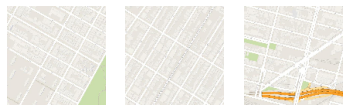

In [ ]:
from matplotlib import pyplot
#--plot images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainimages[i].astype('uint8'))

In [ ]:
#--convert dataset to tensorflow
#BATCH_SIZE=256;
BATCH_SIZE = 50
BUFFER_SIZE = 1000
#traindataset = tf.data.Dataset.from_tensor_slices(trainimages).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
traindataset = tf.data.Dataset.from_tensors(trainimages).shuffle(BUFFER_SIZE)

In [ ]:
traindataset
#tf.data.experimental.get_single_element(traindataset)

<ShuffleDataset shapes: (1096, 128, 128, 3), types: tf.float32>

In [ ]:
#--Building generator network, using material from https://www.manning.com/books/gans-in-action

def make_generator_model(img_shape, z_dim):
  model = Sequential()
  #model.add(Dense(128, input_dim=z_dim))
  model.add(Dense(64, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(128 * 128 * 3, activation='tanh'))
  #model.add(Dense(256 * 256 * 3, activation='tanh'))
  model.add(Reshape(img_shape))
  return model

#Building discriminator network
def make_discriminator_model(img_shape):
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  #model.add(Dense(128))
  model.add(Dense(64))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(3, activation='sigmoid'))
  return model

In [ ]:
#model input dimensions
# img_rows = 256
# img_cols = 256
img_rows = 128
img_cols = 128
channels = 3
img_shape = (img_rows, img_cols, channels)
z_dim = 100

In [ ]:
# Some code to help save checkpoints in case your notebook crashes
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [ ]:
#infrastructure taken from https://www.tensorflow.org/tutorials/generative/dcgan

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, generator, discriminator, generator_optimizer, discriminator_optimizer):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
#@title Default title text
gans=[]
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
    # Instaniate your models
    gen = make_generator_model(img_shape,z_dim)
    discrim = make_discriminator_model(img_shape)

  #  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
   #                             discriminator_optimizer=discriminator_optimizer,
   #                             generator=gen,
    #                            discriminator=discrim)
    for image_batch in dataset:
      train_step(image_batch,gen,discrim,generator_optimizer,discriminator_optimizer)

    # Save the model every 15 epochs
    #if (epoch + 1) % 15 == 0:
     # checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    #gans.append(gen)
  return gen

In [ ]:
gen = train(traindataset,10000)

Time for epoch 1 is 1.5228519439697266 sec
Time for epoch 2 is 0.9852867126464844 sec
Time for epoch 3 is 0.9837028980255127 sec
Time for epoch 4 is 1.0774354934692383 sec
Time for epoch 5 is 1.0082168579101562 sec
Time for epoch 6 is 0.9986624717712402 sec
Time for epoch 7 is 0.9774014949798584 sec
Time for epoch 8 is 0.9745016098022461 sec
Time for epoch 9 is 0.9762814044952393 sec
Time for epoch 10 is 0.9929757118225098 sec
Time for epoch 11 is 0.9876699447631836 sec
Time for epoch 12 is 0.9728574752807617 sec
Time for epoch 13 is 0.9965195655822754 sec
Time for epoch 14 is 0.968907356262207 sec
Time for epoch 15 is 1.0026769638061523 sec
Time for epoch 16 is 0.9883887767791748 sec
Time for epoch 17 is 0.9896574020385742 sec
Time for epoch 18 is 0.99375319480896 sec
Time for epoch 19 is 0.9713125228881836 sec
Time for epoch 20 is 0.9851996898651123 sec
Time for epoch 21 is 1.0035083293914795 sec
Time for epoch 22 is 1.0143427848815918 sec
Time for epoch 23 is 1.0080811977386475 sec


In [ ]:
len(gans) # list "gans" has all the epochs' results stored inside of it

In [ ]:
#plot gan created in final epoch
fig=plt.figure(figsize=(10, 10))
#for i in range(10):
#fig.add_subplot(1, len(gans), i+1)
gan_boss = gen
#plt.imshow( tf.reshape(gan_boss(np.random.randn(0, 1, 100)), (128, 128, 3)) )
plt.imshow( np.reshape((0.5 * gan_boss.predict(np.random.normal(0,1,(1,100))) + 0.5), (128, 128, 3)))

plt.axis('off')

# end for loop
plt.show()